####  **Import Libraries and modules**

In [21]:
import numpy as np
import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.datasets import mnist
from keras import backend as K

import time
from matplotlib import pyplot as plt
%matplotlib inline

from google.colab import drive

drive.mount('/content/gdrive')
dir="/content/gdrive/My Drive/Colab Notebooks/EVA/Weights/Assign5/"

!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive	sample_data


### Load pre-shuffled MNIST data into train and test sets
Plotting a sample image from the dataset 

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


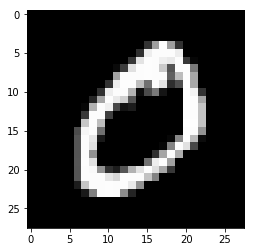

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print (x_train.shape)

plt.imshow(x_train[1], cmap='gray')

In [0]:
X_train = x_train.reshape(x_train.shape[0], 28, 28,1)
X_test = x_test.reshape(x_test.shape[0], 28, 28,1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Image standardisation
X_train /= 255
X_test /= 255

One hot encoding the labels from training and test set. Each 1d label is converted to 10d sparse matrix. Eg, digit 2 becomes [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]

In [12]:
print(y_train[1])
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

Y_train[1]

0


array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [0]:
m = X_train.shape[0]

def custom_loss(custom_model, lamda):
  model_layers = custom_model.layers # type list where each el is Conv2D obj etc.
  #print(model_layers)
  reg_wts = 0
  
  for idx, layer in enumerate(model_layers):
    layer_wts = model_layers[idx].get_weights() # type list
    #print(len(layer_wts), layer_wts)
    
    if len(layer_wts) > 0: # activation, dropout layers do not have any weights
      layer_wts = model_layers[idx].get_weights()[0] #type ndarray, 3,3,1,16 : layer1 output
      reg_wts += np.sum(layer_wts**2)
      
  print("Lambda: %f, Reg. loss: %f" %(lamda, reg_wts) )   
  reg_wts = reg_wts * (lamda/(2*m))
      
  def total_loss(y_true, y_pred):   
    return K.categorical_crossentropy(y_true, y_pred) + reg_wts
  
  return total_loss     
  

In [0]:
def build_model_with_param_lamda(lamda):
  model = Sequential()

  model.add(Conv2D(16, kernel_size=(3, 3), use_bias=False, input_shape=(28,28,1))) #26
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Conv2D(32, (3, 3), use_bias=False)) #24
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Conv2D(10, (1, 1), activation='relu', use_bias=False))
  model.add(MaxPooling2D(pool_size=(2, 2)))#12

  model.add(Conv2D(16, (3, 3), use_bias=False))#10
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Conv2D(16, (3, 3), use_bias=False))#8
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Conv2D(16, (3, 3), use_bias=False))#6
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Conv2D(16, (3, 3), use_bias=False))#4
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Conv2D(10, (4, 4))) 

  model.add(Flatten())
  model.add(Activation('softmax'))
  
  model.compile(loss=custom_loss(model, lamda), optimizer='adam', metrics=['accuracy']) 
  
  return model

#### Grid search for custom_loss parameter lambda
lamda=0.006 is best

In [10]:
keras_model = KerasClassifier(build_fn=build_model_with_param_lamda, epochs=50, batch_size=128, verbose=0)

# define the grid search parameters
lamda = [0.006, 0.008, 0.01, 0.02]
param_dist = dict(lamda=lamda)

grid_search = GridSearchCV(estimator=keras_model, param_grid=param_dist, n_jobs=-1)
print("GridSearch created")
start = time.time()
grid_search.fit(X_train, Y_train)
print("GridSearchCV took %.2f seconds"
      " parameter settings." % ((time.time() - start)))

# Show the results
print("Best score: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
print()

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
score = grid_search.score(X_train, Y_train)
print(score)

# all_train, all_test = list(), list()
# all_train.append(train_acc)
# all_test.append(test_acc)
# plot train and test means
# plt.plot(values, all_train, label='train', marker='o')
# plt.plot(values, all_test, label='test', marker='o')
# plt.legend()
# plt.show()

GridSearch created


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
W0904 10:15:10.215602 140388723337088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 10:15:10.241031 140388723337088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder in

Lambda: 0.006000, Reg. loss: 223.272539


W0904 10:15:12.074058 140388723337088 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


GridSearchCV took 4236.49 seconds parameter settings.
Best score: 0.992467 using {'lamda': 0.006}
0.992467 (0.000239) with: {'lamda': 0.006}
0.991083 (0.000572) with: {'lamda': 0.008}
0.991583 (0.001592) with: {'lamda': 0.01}
0.991683 (0.000419) with: {'lamda': 0.02}
0.9985333333015441


In [0]:
def build_model_with_param_lr(learn_rate):
  print("Learning rate", learn_rate)
  model = Sequential()

  model.add(Conv2D(16, kernel_size=(3, 3), use_bias=False, input_shape=(28,28,1))) #26
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Conv2D(32, (3, 3), use_bias=False)) #24
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Conv2D(10, (1, 1), activation='relu', use_bias=False))
  model.add(MaxPooling2D(pool_size=(2, 2)))#12

  model.add(Conv2D(16, (3, 3), use_bias=False))#10
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Conv2D(16, (3, 3), use_bias=False))#8
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Conv2D(16, (3, 3), use_bias=False))#6
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Conv2D(16, (3, 3), use_bias=False))#4
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Conv2D(10, (4, 4))) 

  model.add(Flatten())
  model.add(Activation('softmax'))
  
  optimizer = Adam(lr=learn_rate)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  
  return model

#### Randomized search values for optimizer parameter 'lr'

In [14]:
keras_model = KerasClassifier(build_fn=build_model_with_param_lr, epochs=50, batch_size=128, verbose=0)

# define the random search parameters
learn_rate = [0.0005, 0.0007, 0.001, 0.002, 0.003]

param_dist = dict(learn_rate=learn_rate)

random_search = RandomizedSearchCV(estimator=keras_model, param_distributions=param_dist,
                                   n_jobs=-1, iid=False)

print("Starting random search training")
start = time.time()
random_search.fit(X_train, Y_train)
print("RandomizedSearchCV took %.2f seconds"
      " parameter settings." % ((time.time() - start)))

# Show the results
print("Best score: %f using %s" % (random_search.best_score_, random_search.best_params_))
print()

means = random_search.cv_results_['mean_test_score']
stds = random_search.cv_results_['std_test_score']
params = random_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Starting random search training


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Learning rate 0.0005
RandomizedSearchCV took 5057.05 seconds parameter settings.
Best score: 0.992517 using {'learn_rate': 0.0005}
0.992517 (0.000290) with: {'learn_rate': 0.0005}
0.991517 (0.000779) with: {'learn_rate': 0.0007}
0.991267 (0.000193) with: {'learn_rate': 0.001}
0.991900 (0.000816) with: {'learn_rate': 0.002}
0.991350 (0.000579) with: {'learn_rate': 0.003}


In [0]:
import sklearn
print(sklearn.__version__)
print(keras.__version__)

0.21.3
2.2.5


#### Passing callback to keras classifier wrapper for scikit-learn - done for checkpoint, but the variable monitored could be only training accuracy or loss. Hence was not useful.

In [0]:
filepath = dir + "GridSearch-{epoch:02d}-{acc:.4f}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, period=2, mode='max')
early_stopper = EarlyStopping(monitor='val_loss', patience=10)
keras_model = KerasClassifier(build_fn=build_model_with_param_lr, epochs=50, batch_size=128, verbose=0, 
                              callbacks=[early_stopper])

# define the grid search parameters
learn_rate = [0.0001, 0.0003, 0.0005, 0.0007, 0.0009]
param_dist = dict(learn_rate=learn_rate)

grid_search = GridSearchCV(estimator=keras_model, param_grid=param_dist, verbose=1,
                           iid=False, n_jobs=-1)

print("Starting grid search training")

start = time.time()
#grid_search.fit(X_train, Y_train, callbacks=[checkpoint])
grid_search.fit(X_train, Y_train)
print("GridSearchCV took %.2f seconds"
      " parameter settings." % ((time.time() - start)))

# Show the results
print("Best score: %f using %s" % (grid_search.best_score_, grid_search.best_params_))


Starting grid search training
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 77.4min finished
W0901 19:20:44.615673 140489569757056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0901 19:20:44.641700 140489569757056 deprecation_wrapper.py:119] From /usr/local

Learning rate 0.0007


W0901 19:20:45.447993 140489569757056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2041: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0901 19:20:45.592709 140489569757056 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0901 19:20:45.813680 140489569757056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0901 19:20:46.675599 140489569757056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: Th

Epoch 1/50
60000/60000 [==============================] - 12s 204us/step - loss: 0.4975 - acc: 0.8523

Epoch 00001: acc improved from -inf to 0.85230, saving model to /content/gdrive/My Drive/Colab Notebooks/EVA/Weights/Assign5/GridSearch-01-0.8523.hdf5
Epoch 2/50
60000/60000 [==============================] - 10s 168us/step - loss: 0.1046 - acc: 0.9688

Epoch 00002: acc improved from 0.85230 to 0.96882, saving model to /content/gdrive/My Drive/Colab Notebooks/EVA/Weights/Assign5/GridSearch-02-0.9688.hdf5
Epoch 3/50
60000/60000 [==============================] - 10s 170us/step - loss: 0.0736 - acc: 0.9781

Epoch 00003: acc improved from 0.96882 to 0.97808, saving model to /content/gdrive/My Drive/Colab Notebooks/EVA/Weights/Assign5/GridSearch-03-0.9781.hdf5
Epoch 4/50
60000/60000 [==============================] - 10s 170us/step - loss: 0.0584 - acc: 0.9820

Epoch 00004: acc improved from 0.97808 to 0.98200, saving model to /content/gdrive/My Drive/Colab Notebooks/EVA/Weights/Assign5/G

#### Image normalisation

In [22]:
# Entire dataset mean and standard deviation
print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (X_train.mean(), X_train.std(), X_test.mean(), X_test.std()))

# Create generator to normalize images
# feature-wise is per-dataset, sample-wise is per-image
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# Calculate mean, var on training dataset, required if featurewise_center/featurewise_std_normalization set to True
datagen.fit(X_train)
print('Train data generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))

Statistics train=0.131 (0.308), test=0.133 (0.310)
Train data generator mean=0.131, std=0.308


In [23]:
batch_size = 128

# get batch of the training set
train_iterator = datagen.flow(X_train, Y_train, batch_size=batch_size, shuffle=True, seed=42) # default is true
batchX, batchy = train_iterator.next()

valid_iterator = datagen.flow(X_test, Y_test, batch_size=batch_size, shuffle=True, seed=42)

print('Batches train=%d, test=%d' % (len(train_iterator), len(valid_iterator)))

Batches train=469, test=79


### Final run for 40 epochs with lambda 0.006 and lr=0.0005

In [0]:
def build_model():
  model = Sequential()

  model.add(Conv2D(16, kernel_size=(3, 3), use_bias=False, input_shape=(28,28,1))) #26
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Conv2D(32, (3, 3), use_bias=False)) #24
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Conv2D(10, (1, 1), activation='relu', use_bias=False))
  model.add(MaxPooling2D(pool_size=(2, 2)))#12

  model.add(Conv2D(16, (3, 3), use_bias=False))#10
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Conv2D(16, (3, 3), use_bias=False))#8
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Conv2D(16, (3, 3), use_bias=False))#6
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Conv2D(16, (3, 3), use_bias=False))#4
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Conv2D(10, (4, 4))) 

  model.add(Flatten())
  model.add(Activation('softmax'))
  
  return model

#### Best validation accuracy was 99.54% which came at epoch 32, with training accuracy at 99.39%

In [27]:
custom_model = build_model()
#custom_model.summary()
custom_model.compile(loss=custom_loss(custom_model, lamda=0.006), optimizer=Adam(lr=0.0005), metrics=['accuracy'])

file = dir + "GridSearch-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model_hist = custom_model.fit_generator(train_iterator, steps_per_epoch=len(train_iterator),                     
                    validation_data=valid_iterator, validation_steps=len(valid_iterator),
                    epochs=40, verbose=1, callbacks=[checkpoint])

Lambda: 0.006000, Reg. loss: 221.904478
Epoch 1/40
469/469 [==============================] - 16s 33ms/step - loss: 0.6137 - acc: 0.8188 - val_loss: 0.1550 - val_acc: 0.9576

Epoch 00001: val_acc improved from -inf to 0.95760, saving model to /content/gdrive/My Drive/Colab Notebooks/EVA/Weights/Assign5/GridSearch-01-0.9576.hdf5
Epoch 2/40
469/469 [==============================] - 13s 28ms/step - loss: 0.1418 - acc: 0.9594 - val_loss: 0.0620 - val_acc: 0.9810

Epoch 00002: val_acc improved from 0.95760 to 0.98100, saving model to /content/gdrive/My Drive/Colab Notebooks/EVA/Weights/Assign5/GridSearch-02-0.9810.hdf5
Epoch 3/40
469/469 [==============================] - 13s 27ms/step - loss: 0.0894 - acc: 0.9736 - val_loss: 0.0589 - val_acc: 0.9822

Epoch 00003: val_acc improved from 0.98100 to 0.98220, saving model to /content/gdrive/My Drive/Colab Notebooks/EVA/Weights/Assign5/GridSearch-03-0.9822.hdf5
Epoch 4/40
469/469 [==============================] - 13s 27ms/step - loss: 0.0683 -

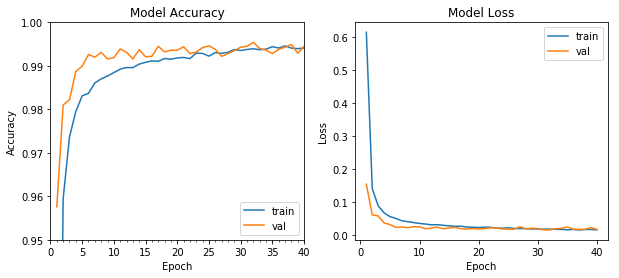

In [33]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(10,4))
    # Set axis properties [xmin, xmax, ymin, ymax]
    axs[0].axis([0,40,0.95,1])
    
    # Plot training & validation accuracy values    
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    
    # Plot training & validation loss values
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(model_hist)

In [29]:
custom_model = build_model()
custom_model.compile(loss=custom_loss(custom_model, lamda=0.006), optimizer=Adam(lr=0.0005), metrics=['accuracy'])

custom_model.load_weights(dir + "GridSearch-32-0.9954.hdf5")
print("Loaded model from disk ")

custom_model.evaluate_generator(generator=valid_iterator, steps=len(valid_iterator),verbose=1)

Lambda: 0.006000, Reg. loss: 223.439027
Loaded model from disk 
79/79 [==============================] - 1s 16ms/step


[0.016863743467372842, 0.9954]